In [1]:
import pandas as pd
import numpy as np

In [79]:
transactions = pd.read_csv('course/vtb/transactions.csv')
clickstream = pd.read_csv('course/vtb/clickstream.csv')
train_matching = pd.read_csv('course/vtb/train_matching.csv')

In [136]:
train_matching = pd.read_csv('course/vtb/train_matching.csv')

In [81]:
transactions['transaction_dttm'] = pd.to_datetime(transactions['transaction_dttm'])
transactions['hour']=transactions.transaction_dttm.dt.hour
transactions['dow']=transactions.transaction_dttm.dt.dayofweek
transactions['month']=transactions.transaction_dttm.dt.month
transactions['date']=transactions.transaction_dttm.dt.date
transactions['hour_minute']=transactions.transaction_dttm.dt.strftime('%H:%M')

In [82]:
def is_not_rub(row):
    if row.currency_rk in [50,60]:
        return(1)
    else:
        return(0)
transactions['not_rub']=transactions.apply(lambda row: is_not_rub(row),axis=1)
foreign_currency=transactions[['user_id','not_rub']]
foreign_currency=foreign_currency.drop_duplicates()
foreign_currency.index=foreign_currency['user_id']
foreign_currency=foreign_currency.drop('user_id', axis=1)

agg_func={'not_rub':['max']}
foreign_currency=foreign_currency.groupby('user_id').agg(agg_func)
foreign_currency.columns=['not_rub']

In [83]:
agg_func={'hour_minute':['nunique']}
transactions_minutes=transactions.groupby(['user_id','date','dow']).agg(agg_func)
transactions_minutes.columns=['nunique']
transactions_minutes=pd.pivot_table(transactions_minutes,index='user_id',columns='dow',values='nunique',aggfunc='mean').fillna(0)
transactions_minutes.columns=['avg_uniq_minutes_per_day_'+str(i)+'_tr'  for i in transactions_minutes.columns]

In [84]:
agg_func={'transaction_amt':['sum','mean','max','min']}

transactions_agg=transactions.groupby(['user_id','month']).agg(agg_func)
transactions_agg=transactions_agg.groupby(['user_id']).agg('mean')
transactions_agg.columns=['_'.join(col).strip()+'_by_month' for col in transactions_agg.columns.values]

In [85]:
transactions['date_shift']=transactions.groupby(['user_id','mcc_code'])['date'].shift(1)
transactions[['date','date_shift']] = transactions[['date','date_shift']].apply(pd.to_datetime) #if conversion required
transactions['date_diff'] = (transactions['date'] - transactions['date_shift']).dt.days

transactions_calc=transactions[['user_id','mcc_code','date','date_shift','date_diff']]
transactions_calc=transactions_calc.drop_duplicates()
transactions_calc=transactions_calc.dropna()

transactions_calc=pd.pivot_table(transactions_calc,index='user_id',columns='mcc_code',values='date_diff',aggfunc='mean').fillna(0)
transactions_calc.columns=[str(i)+'_avg_date_diff'+'_tr'  for i in transactions_calc.columns]

In [86]:
tr_h=pd.pivot_table(transactions,index='user_id',columns='hour',values='transaction_amt',aggfunc='count').fillna(0)
tr_h['summ']=tr_h.sum(axis=1)
for i in tr_h.columns[:-1]:
    tr_h[i]/=tr_h['summ']
tr_h.columns=['prc_h_tr_'+str(i) for i in tr_h.columns]
tr_h=tr_h.rename(columns={'prc_h_tr_summ':'summ'})
tr_h=tr_h.drop(['summ'],axis=1)

In [87]:
tr_dow=pd.pivot_table(transactions,index='user_id',columns='dow',values='transaction_amt',aggfunc='count').fillna(0)
tr_dow['summ']=tr_dow.sum(axis=1)
for i in tr_dow.columns[:-1]:
    tr_dow[i]/=tr_dow['summ']
tr_dow.columns=['prc_dow_tr_'+str(i) for i in tr_dow.columns]
tr_dow=tr_dow.rename(columns={'prc_dow_tr_summ':'summ'})
tr_dow=tr_dow.drop(['summ'],axis=1)

In [134]:
tr_ctg=pd.pivot_table(transactions,index='user_id',columns='mcc_code',values='transaction_amt',aggfunc='sum').fillna(0)
tr_ctg['summ']=tr_ctg.sum(axis=1)
for i in tr_ctg.columns[:-1]:
    tr_ctg[i]/=tr_ctg['summ']
tr_ctg.columns=['prc_ctg_sum_tr_'+str(i) for i in tr_ctg.columns]
tr_ctg=tr_ctg.rename(columns={'prc_ctg_sum_tr_summ':'summ'})
tr_ctg=tr_ctg.drop(['summ'],axis=1)

In [88]:
clickstream.timestamp=pd.to_datetime(clickstream.timestamp)
clickstream['hour']=clickstream.timestamp.dt.hour
clickstream['dow']=clickstream.timestamp.dt.dayofweek
clickstream['date']=clickstream.timestamp.dt.date
clickstream['hour_minute']=clickstream.timestamp.dt.strftime('%H:%M')

In [89]:
agg_func={'new_uid':['nunique']}
clickstream_unq_device=clickstream.groupby(['user_id']).agg(agg_func)
clickstream_unq_device.columns=['cnt_unq_device_cl']

In [90]:
agg_func={'hour_minute':['nunique']}
clickstream_minutes=clickstream.groupby(['user_id','date','dow']).agg(agg_func)
clickstream_minutes.columns=['nunique']
clickstream_minutes=pd.pivot_table(clickstream_minutes,index='user_id',columns='dow',values='nunique',aggfunc='mean').fillna(0)
clickstream_minutes.columns=['avg_uniq_minutes_per_day_'+str(i)+'_cl'  for i in clickstream_minutes.columns]

In [91]:
clickstream['date_shift']=clickstream.groupby(['user_id','cat_id'])['date'].shift(1)
clickstream[['date','date_shift']] = clickstream[['date','date_shift']].apply(pd.to_datetime) #if conversion required
clickstream['date_diff'] = (clickstream['date'] - clickstream['date_shift']).dt.days

clickstream_calc=clickstream[['user_id','cat_id','date','date_shift','date_diff']]
clickstream_calc=clickstream_calc.drop_duplicates()
clickstream_calc=clickstream_calc.dropna()

clickstream_calc=pd.pivot_table(clickstream_calc,index='user_id',columns='cat_id',values='date_diff',aggfunc='mean').fillna(0)
clickstream_calc.columns=[str(i)+'_avg_date_diff'+'_cl'  for i in clickstream_calc.columns]

In [92]:
cl_h=pd.pivot_table(clickstream,index='user_id',columns='hour',values='timestamp',aggfunc='count').fillna(0)
cl_h['summ']=cl_h.sum(axis=1)
for i in cl_h.columns[:-1]:
    cl_h[i]/=cl_h['summ']
cl_h.columns=['prc_h_cl_'+str(i) for i in cl_h.columns]
cl_h=cl_h.rename(columns={'prc_h_cl_summ':'summ'})
cl_h=cl_h.drop(['summ'],axis=1)

In [93]:
cl_dow=pd.pivot_table(clickstream,index='user_id',columns='dow',values='timestamp',aggfunc='count').fillna(0)
cl_dow['summ']=cl_dow.sum(axis=1)
for i in cl_dow.columns[:-1]:
    cl_dow[i]/=cl_dow['summ']
cl_dow.columns=['prc_dow_cl_'+str(i) for i in cl_dow.columns]
cl_dow=cl_dow.rename(columns={'prc_dow_cl_summ':'summ'})
cl_dow=cl_dow.drop(['summ'],axis=1)

In [135]:
cl_ctg=pd.pivot_table(clickstream,index='user_id',columns='cat_id',values='timestamp',aggfunc='count').fillna(0)
cl_ctg['summ']=cl_ctg.sum(axis=1)
for i in cl_ctg.columns[:-1]:
    cl_ctg[i]/=cl_ctg['summ']
cl_ctg.columns=['prc_ctg_cnt_cl_'+str(i) for i in cl_ctg.columns]
cl_ctg=cl_ctg.rename(columns={'prc_ctg_cnt_cl_summ':'summ'})
cl_ctg=cl_ctg.drop(['summ'],axis=1)

In [94]:
#Из базового решения
bankclient_embed = transactions.pivot_table(index = 'user_id', 
                         values=['transaction_amt'],
                         columns=['mcc_code'],
                         aggfunc=['sum','mean', 'count']).fillna(0)

bankclient_embed.columns = ['tr-'+f'{str(i[0])}-{str(i[2])}' for i in bankclient_embed.columns]

In [95]:
#Из базового решения
clickstream_embed = clickstream.pivot_table(index = 'user_id', 
                         values=['timestamp'],
                         columns=['cat_id'],
                         aggfunc=['count']).fillna(0)

clickstream_embed.columns = ['cl-'+f'{str(i[0])}-{str(i[2])}' for i in clickstream_embed.columns]

In [137]:
def gen_random_for_negative(x, k, list_of_uniq):
    while True:
        final_list = np.random.choice(list_of_uniq, size=k, replace=False)
        if x not in final_list:
            return final_list

In [138]:
list_of_uniq_rtk = train_matching['rtk'].unique()
list_of_uniq_bank = train_matching['bank'].unique()
train_matching['negatives'] = train_matching['rtk'].apply(
                        lambda x: gen_random_for_negative(x, 10, list_of_uniq_rtk))

In [139]:
train_matching['target'] = 1
pos_part = train_matching[['bank', 'rtk', 'target']]
neg_part = train_matching[['bank', 'negatives']].explode('negatives')
neg_part['target'] = 0
neg_part.columns = pos_part.columns

In [140]:
full_dataset = pd.concat([pos_part, neg_part]).sort_values(by='bank')

In [141]:
full_dataset.target.value_counts()

0    175810
1     17581
Name: target, dtype: int64

### Новое решение

In [4]:
transactions=transactions.sort_values(by=['user_id','transaction_dttm'],ascending=True)
clickstream=clickstream.sort_values(by=['user_id','timestamp'],ascending=True)
transactions_wv=transactions.copy()
clickstream_wv=clickstream.copy()

In [5]:
transactions_wv['mcc_code']=transactions_wv['mcc_code'].astype('str')
clickstream_wv['cat_id']=clickstream_wv['cat_id'].astype('str')

In [15]:
transactions_wv_by_user_id = transactions_wv.groupby("user_id").apply(lambda order: ' '.join(order['mcc_code'].tolist()))

transactions_wv_by_user_id = pd.DataFrame(transactions_wv_by_user_id,columns=['all_orders'])
print(f'Number of orders: {transactions_wv_by_user_id.shape[0]}')
transactions_wv_by_user_id.reset_index(inplace=True)
transactions_wv_by_user_id.user_id = transactions_wv_by_user_id.user_id.astype(str)

transactions_wv_by_user_id.head()

Number of orders: 22533


,user_id,all_orders
0,000932580e404dafbecd5916d4640938,5411 5499 5499 4829 5411 5814 4789 5411 5814 5...
1,0009e36b42cb4caeb928a1e596819495,5411 4121 5399 5399 5411 5912 5411 4111 4111 5...
2,000b29acb6bd44f99473c1be5ca28f3c,5814 5651 5411 5814 5541 -1 5814 5912 5814 549...
3,000c5327d99941fe934169838c65b92c,5422 5411 5411 5814 5541 5411 5814 5411 5533 5...
4,000e0d54d7c945ebb8f6f855972e8396,5541 5411 5411 5812 5812 5912 5411 5499 5999 5...


In [17]:
user_id_tr=list(transactions_wv_by_user_id.user_id)
len(user_id_tr)

22533

In [ ]:
user_id_tr=list(clickstream_wv_by_user_id.user_id)
print(len(user_id_tr))

d2v_model_cl = Doc2Vec(min_count = 5,
                     vector_size = 100,
                     window=5)
it = TaggedDocumentIterator(clickstream_wv_by_user_id)
train_corpus = list(it)

d2v_model_cl.build_vocab(train_corpus)
d2v_model_cl.train(train_corpus,total_examples=d2v_model_cl.corpus_count, epochs=5)

In [25]:
from gensim.models.doc2vec import Doc2Vec,TaggedDocument

class TaggedDocumentIterator(object):
    def __init__(self, df):
       self.df = df
    def __iter__(self):
        for row in self.df.itertuples():
            yield TaggedDocument(words=dict(row._asdict())['all_orders'].split(),tags=[dict(row._asdict())['user_id']])

d2v_model_tr = Doc2Vec(min_count = 5,
                     vector_size = 100,
                     window=5)

In [26]:
it = TaggedDocumentIterator(transactions_wv_by_user_id)
train_corpus = list(it)

d2v_model_tr.build_vocab(train_corpus)

In [27]:
%%time
d2v_model_tr.train(train_corpus,total_examples=d2v_model_tr.corpus_count, epochs=2)

CPU times: user 36.6 s, sys: 2.16 s, total: 38.7 s
Wall time: 19.6 s


In [39]:
tr_vectors = {arg:d2v_model_tr.docvecs[ind] for ind,arg in enumerate(user_id_tr)}
tr_vectors_df=pd.DataFrame(tr_vectors)
tr_vectors_df=tr_vectors_df.transpose()
tr_vectors_df.insert(0,'user_id',tr_vectors_df.index)
tr_vectors_df=tr_vectors_df.reset_index(drop=True)
X_doc=tr_vectors_df

/opt/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  """Entry point for launching an IPython kernel.


In [68]:
cl_vectors = {arg:d2v_model_cl.docvecs[ind] for ind,arg in enumerate(user_id_cl)}
cl_vectors_df=pd.DataFrame(cl_vectors)
cl_vectors_df=cl_vectors_df.transpose()
cl_vectors_df.insert(0,'user_id',cl_vectors_df.index)
cl_vectors_df=cl_vectors_df.reset_index(drop=True)
X_doc=cl_vectors_df

/opt/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  """Entry point for launching an IPython kernel.


In [69]:
X_doc[X_doc.columns[1:]][:3]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.712882,-0.260436,-0.038566,0.464499,0.148361,-0.495836,-0.315095,0.722321,-0.381783,-0.605015,...,-0.015543,0.425476,-0.013704,-0.156872,0.113921,0.960199,-0.088734,-0.031198,0.060410,0.277160
1,0.041403,-0.881647,-0.032633,0.235427,-0.180747,-0.487254,0.654850,0.420261,-0.244776,0.175057,...,0.481096,-0.403264,0.151834,0.202985,0.389647,1.123604,0.475146,-0.700294,0.448765,0.162389
2,0.072154,-1.136976,-0.548022,0.445798,-0.245682,-1.411030,-0.070584,1.150250,-1.128178,-0.711124,...,-0.425064,0.728492,-0.184627,-0.432685,0.109181,0.490656,-0.911945,-0.822254,0.269992,0.340886


In [70]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

distance_matrix_doc = pairwise_distances(X_doc[X_doc.columns[1:]], X_doc[X_doc.columns[1:]], metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

/home/dvkhoro6/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19623 samples in 1.382s...
[t-SNE] Computed neighbors for 19623 samples in 12.985s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19623
[t-SNE] Computed conditional probabilities for sample 2000 / 19623
[t-SNE] Computed conditional probabilities for sample 3000 / 19623
[t-SNE] Computed conditional probabilities for sample 4000 / 19623
[t-SNE] Computed conditional probabilities for sample 5000 / 19623
[t-SNE] Computed conditional probabilities for sample 6000 / 19623
[t-SNE] Computed conditional probabilities for sample 7000 / 19623
[t-SNE] Computed conditional probabilities for sample 8000 / 19623
[t-SNE] Computed conditional probabilities for sample 9000 / 19623
[t-SNE] Computed conditional probabilities for sample 10000 / 19623
[t-SNE] Computed conditional probabilities for sample 11000 / 19623
[t-SNE] Computed conditional probabilities for sample 12000 / 19623
[t-SNE] Computed conditional probabilities for sa

In [71]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

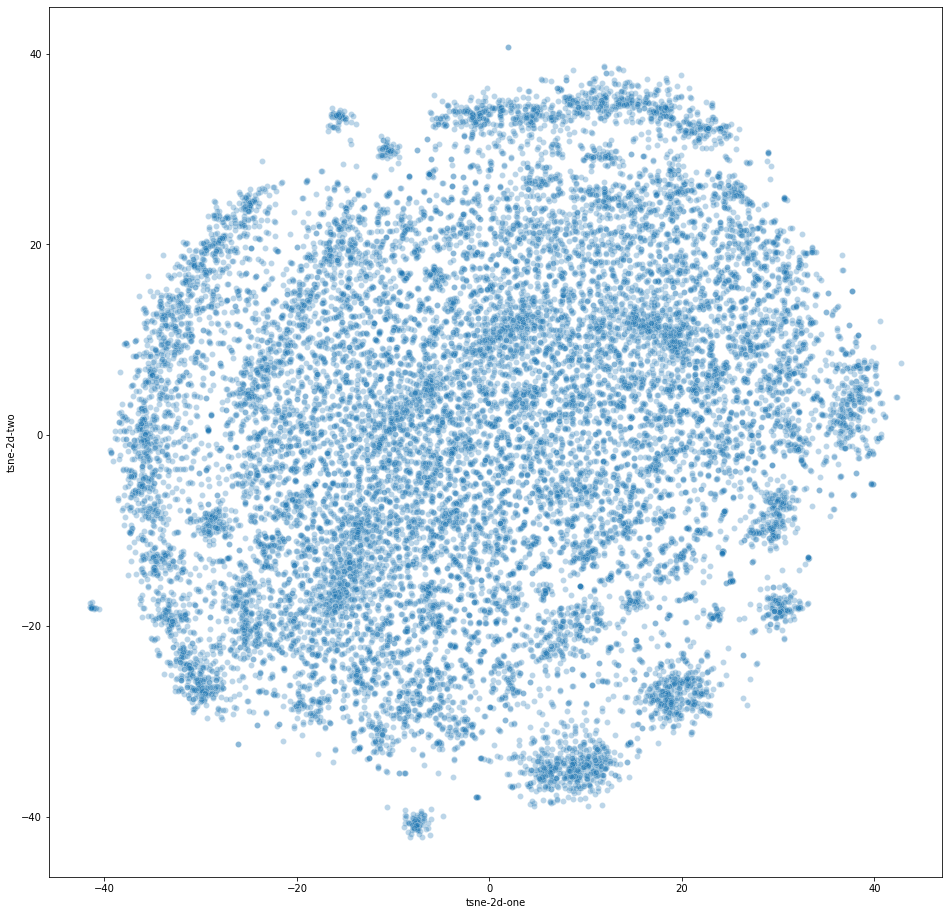

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.3
)
plt.show()

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

In [ ]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc[X_doc.columns[1:]])).labels_.astype(float)

silhouette_list = []
for k in range(2, 13, 1):
    latent_clusters = cluster_cosine(X_doc[X_doc.columns[1:]] , k)
    silhouette_avg = silhouette_score(X_doc[X_doc.columns[1:]], latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(2,22,1), silhouette_list);

In [74]:
N_CLUSTER = 12

latent_clusters = cluster_cosine(X_doc[X_doc.columns[1:]], N_CLUSTER)
doc_vec_end = X_doc.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

doc_vec_end['label'].value_counts()

9.0     2782
8.0     2354
0.0     2319
11.0    2193
4.0     2000
6.0     1993
2.0     1638
10.0    1462
5.0     1013
3.0      847
7.0      536
1.0      486
Name: label, dtype: int64

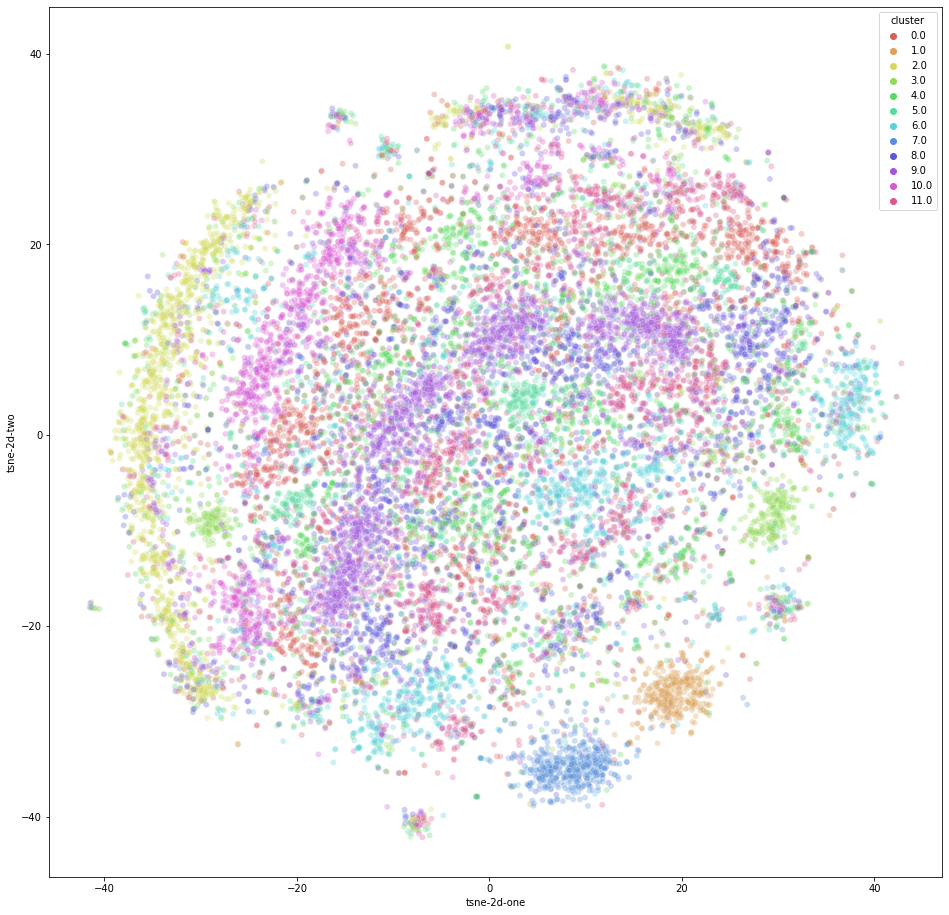

In [75]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.3
);
plt.show();

In [63]:
tr_vectors_df=doc_vec_end
tr_vectors_df.to_csv('course/vtb/tr_vectors_dv.csv',index=False)

In [76]:
cl_vectors_df=doc_vec_end
cl_vectors_df.to_csv('course/vtb/cl_vectors_dv.csv',index=False)

In [66]:
clickstream_wv_by_user_id = clickstream_wv.groupby("user_id").apply(lambda order: ' '.join(order['cat_id'].tolist()))

clickstream_wv_by_user_id = pd.DataFrame(clickstream_wv_by_user_id,columns=['all_orders'])
print(f'Number of orders: {clickstream_wv_by_user_id.shape[0]}')
clickstream_wv_by_user_id.reset_index(inplace=True)
clickstream_wv_by_user_id.user_id = clickstream_wv_by_user_id.user_id.astype(str)

clickstream_wv_by_user_id.head()

Number of orders: 19623


,user_id,all_orders
0,000143baebad4467a23b98c918ccda19,165 165 308 931 931 931 503 535 535 931 535 16...
1,000a8d3cdef3455d990e97730a2cef43,12 931 165 503 931 165 165 931 931 503 556 931...
2,000c399352314e759041dc1651fe6980,165 391 535 165 770 770 770 770 535 931 931 16...
3,000eb2d39f4f4df0afd630c4f11ca049,503 251 770 770 770 770 165 165 165 165 165 50...
4,000fc5be9e974980a1c9728f4866db11,931 535 931 770 1457 25 535 535 535 535 535 14...


In [67]:
%%time
user_id_cl=list(clickstream_wv_by_user_id.user_id)
print(len(user_id_cl))

d2v_model_cl = Doc2Vec(min_count = 5,
                     vector_size = 100,
                     window=5)
it = TaggedDocumentIterator(clickstream_wv_by_user_id)
train_corpus = list(it)

d2v_model_cl.build_vocab(train_corpus)
d2v_model_cl.train(train_corpus,total_examples=d2v_model_cl.corpus_count, epochs=5)

19623
CPU times: user 6min 24s, sys: 20.6 s, total: 6min 45s
Wall time: 3min 45s


In [77]:
tr_vectors_df.set_index('user_id', inplace=True)
cl_vectors_df.set_index('user_id', inplace=True)

In [142]:
full_dataset = full_dataset.merge(bankclient_embed, how='left', left_on='bank', right_index=True)\
               .merge(clickstream_embed, how='left', left_on='rtk', right_index=True)\
               .merge(tr_dow, how='left', left_on='bank', right_index=True)\
               .merge(tr_h, how='left', left_on='bank', right_index=True)\
               .merge(transactions_agg, how='left', left_on='bank', right_index=True)\
               .merge(transactions_minutes, how='left', left_on='bank', right_index=True)\
               .merge(transactions_calc, how='left', left_on='bank', right_index=True)\
               .merge(foreign_currency, how='left', left_on='bank', right_index=True)\
               .merge(cl_dow, how='left', left_on='rtk', right_index=True)\
               .merge(cl_h, how='left', left_on='rtk', right_index=True)\
               .merge(clickstream_minutes, how='left', left_on='rtk', right_index=True)\
               .merge(clickstream_calc, how='left', left_on='bank', right_index=True)\
               .merge(clickstream_unq_device, how='left', left_on='rtk', right_index=True)\
               .merge(tr_vectors_df, how='left', left_on='bank', right_index=True)\
               .merge(cl_vectors_df, how='left', left_on='rtk', right_index=True)\
               .merge(tr_ctg, how='left', left_on='bank', right_index=True)\
               .merge(cl_ctg, how='left', left_on='rtk', right_index=True)\
               .fillna(0)

In [143]:
full_dataset[:5]

,bank,rtk,target,tr-sum--1,tr-sum-742,tr-sum-763,tr-sum-780,tr-sum-1520,tr-sum-1711,tr-sum-1731,...,prc_ctg_cnt_cl_1819,prc_ctg_cnt_cl_1840,prc_ctg_cnt_cl_1848,prc_ctg_cnt_cl_1849,prc_ctg_cnt_cl_1850,prc_ctg_cnt_cl_1853,prc_ctg_cnt_cl_1856,prc_ctg_cnt_cl_1857,prc_ctg_cnt_cl_1858,prc_ctg_cnt_cl_1861
3418,000932580e404dafbecd5916d4640938,8a303b24660a4881af2a7992d2bcd600,0,3075.678003,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3418,000932580e404dafbecd5916d4640938,aea28514d2ba462c9fea8a7b85fe04f4,0,3075.678003,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3418,000932580e404dafbecd5916d4640938,12cd46c871cf4dc8aa7766ccac4e13fb,0,3075.678003,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3418,000932580e404dafbecd5916d4640938,e332a053f9fb44feae60f5016bf38e40,0,3075.678003,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3418,000932580e404dafbecd5916d4640938,c56c73b4120e4939a1d2a582d93ef008,0,3075.678003,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
from sklearn.model_selection import train_test_split

train_full,test=train_test_split(full_dataset,test_size=0.3,random_state=5)
train,valid=train_test_split(train_full,test_size=0.3,random_state=5)

In [145]:
X_train=train.drop(['target','bank','rtk'],axis=1)
y_train=train['target']
X_train.shape,y_train.shape

((94761, 3320), (94761,))

In [146]:
y_train.value_counts()

0    86050
1     8711
Name: target, dtype: int64

In [147]:
X_valid=valid.drop(['target','bank','rtk'],axis=1)
y_valid=valid['target']
X_valid.shape,y_valid.shape

((40612, 3320), (40612,))

In [148]:
y_valid.value_counts()

0    36952
1     3660
Name: target, dtype: int64

In [149]:
X_test=test.drop(['target','bank','rtk'],axis=1)
y_test=test['target']
X_test.shape,y_test.shape

((58018, 3320), (58018,))

In [150]:
y_test.value_counts()

0    52808
1     5210
Name: target, dtype: int64

In [151]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn import linear_model, metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score,recall_score,precision_score,confusion_matrix,precision_recall_curve,auc,average_precision_score
from catboost import Pool, CatBoostClassifier,cv
import matplotlib.pyplot as plt
import numpy as np

In [152]:
train_data = Pool(X_train,y_train,has_header=True)
eval_data = Pool(X_valid,y_valid, has_header=True)

In [153]:
%%time

cb_classifier = CatBoostClassifier(iterations=2000, eval_metric='AUC',random_state=42)
cb_classifier.fit(train_data,eval_set=eval_data, metric_period=50, verbose=50, early_stopping_rounds=100)

Learning rate set to 0.072142
0:	test: 0.5835812	best: 0.5835812 (0)	total: 75.1ms	remaining: 2m 30s


50:	test: 0.7250237	best: 0.7255679 (47)	total: 3.62s	remaining: 2m 18s
100:	test: 0.7667201	best: 0.7669609 (98)	total: 7.13s	remaining: 2m 14s
150:	test: 0.7733984	best: 0.7733984 (150)	total: 10.7s	remaining: 2m 10s
200:	test: 0.7778063	best: 0.7778063 (200)	total: 13.8s	remaining: 2m 3s
250:	test: 0.7831221	best: 0.7831267 (249)	total: 17.2s	remaining: 1m 59s
300:	test: 0.7873067	best: 0.7873067 (300)	total: 20.7s	remaining: 1m 56s
350:	test: 0.7898567	best: 0.7899955 (341)	total: 24.5s	remaining: 1m 55s
400:	test: 0.7927317	best: 0.7927317 (400)	total: 28.1s	remaining: 1m 52s
450:	test: 0.7940172	best: 0.7940172 (450)	total: 31.9s	remaining: 1m 49s
500:	test: 0.7955714	best: 0.7955714 (500)	total: 35.4s	remaining: 1m 46s
550:	test: 0.7965194	best: 0.7965924 (515)	total: 39.2s	remaining: 1m 43s
600:	test: 0.7964232	best: 0.7970196 (568)	total: 42.8s	remaining: 1m 39s
650:	test: 0.7968222	best: 0.7970196 (568)	total: 46.5s	remaining: 1m 36s
700:	test: 0.7980969	best: 0.7982017 (690)

In [154]:
print(f"roc_auc_score: {roc_auc_score(y_train, cb_classifier.predict_proba(X_train)[:, 1])}")
recall = recall_score(y_train,cb_classifier.predict(X_train))
print('recall: ', recall)
precision = precision_score(y_train,cb_classifier.predict(X_train))
print('precision: ', precision)
accuracy = accuracy_score(y_train,cb_classifier.predict(X_train))
print('accuracy: ', accuracy)
f1 = f1_score(y_train,cb_classifier.predict(X_train))
print('f1 score: ', f1)
cm = confusion_matrix(y_train,cb_classifier.predict(X_train))
cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
print('матрица ошибок: \n',cm)

roc_auc_score: 0.9457594734021937
recall:  0.23774537940534957
precision:  0.9932853717026379
accuracy:  0.9297812391173584
f1 score:  0.3836606150426084
матрица ошибок: 
 [[ 2071    14]
 [ 6640 86036]]


In [155]:
print(f"roc_auc_score: {roc_auc_score(y_valid, cb_classifier.predict_proba(X_valid)[:, 1])}")
recall = recall_score(y_valid,cb_classifier.predict(X_valid))
print('recall: ', recall)
precision = precision_score(y_valid,cb_classifier.predict(X_valid))
print('precision: ', precision)
accuracy = accuracy_score(y_valid,cb_classifier.predict(X_valid))
print('accuracy: ', accuracy)
f1 = f1_score(y_valid,cb_classifier.predict(X_valid))
print('f1 score: ', f1)
cm = confusion_matrix(y_valid,cb_classifier.predict(X_valid))
cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
print('матрица ошибок: \n',cm)

roc_auc_score: 0.8031127517961567
recall:  0.1737704918032787
precision:  0.9754601226993865
accuracy:  0.9251452772579534
f1 score:  0.29499072356215217
матрица ошибок: 
 [[  636    16]
 [ 3024 36936]]


In [156]:
print(f"roc_auc_score: {roc_auc_score(y_test, cb_classifier.predict_proba(X_test)[:, 1])}")
recall = recall_score(y_test,cb_classifier.predict(X_test))
print('recall: ', recall)
precision = precision_score(y_test,cb_classifier.predict(X_test))
print('precision: ', precision)
accuracy = accuracy_score(y_test,cb_classifier.predict(X_test))
print('accuracy: ', accuracy)
f1 = f1_score(y_test,cb_classifier.predict(X_test))
print('f1 score: ', f1)
cm = confusion_matrix(y_test,cb_classifier.predict(X_test))
cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
print('матрица ошибок: \n',cm)

roc_auc_score: 0.8028694614117968
recall:  0.17293666026871402
precision:  0.9688172043010753
accuracy:  0.925230101003137
f1 score:  0.29348534201954396
матрица ошибок: 
 [[  901    29]
 [ 4309 52779]]


In [157]:
importances = pd.DataFrame(data={
    'features': cb_classifier.feature_names_,
    'fscore': cb_classifier.feature_importances_
}).sort_values('fscore', ascending=False)
importances[:20]

,features,fscore
1590,prc_h_tr_23,2.976046
1984,prc_h_cl_19,2.960501
2329,cnt_unq_device_cl,2.739250
1983,prc_h_cl_18,2.421463
1581,prc_h_tr_14,1.655770
1567,prc_h_tr_0,1.632897
1582,prc_h_tr_15,1.580510
1965,prc_h_cl_0,1.433227
1966,prc_h_cl_1,1.394829
1990,avg_uniq_minutes_per_day_1_cl,1.372980


In [158]:
df_train_x=train.drop(['target','bank','rtk'], axis=1)
df_train_y=train['target']

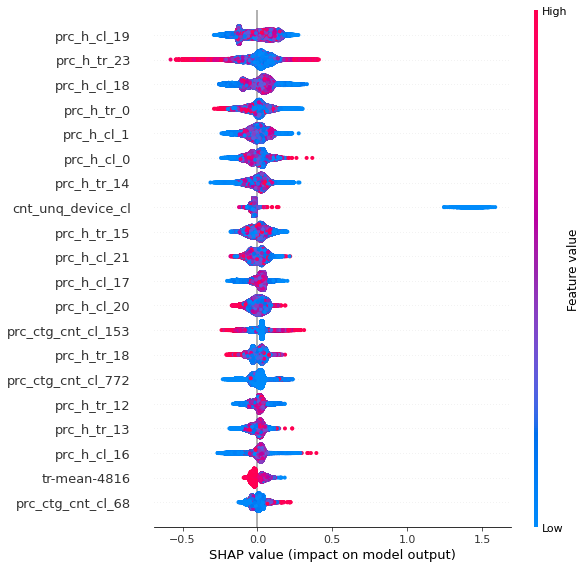

In [159]:
import shap
X_tr = train[cb_classifier.feature_names_]
train_pool = Pool(X_tr, train['target'])
shap_values = cb_classifier.get_feature_importance(train_pool, type='ShapValues')[:, :-1]
shap.summary_plot(shap_values, X_tr)

0.8028694614117968

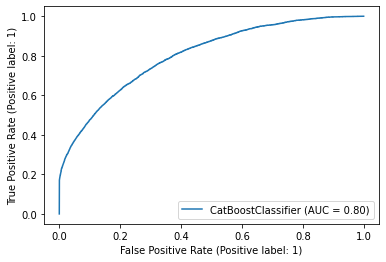

In [160]:
from sklearn.metrics import plot_roc_curve, roc_auc_score

plot_roc_curve(cb_classifier, X_test, y_test)
roc_auc_score(y_test, cb_classifier.predict_proba(X_test)[:,1])

In [161]:
cb_classifier.save_model('course/vtb/data_fusion_matching_dv_v2.cbm')

In [162]:
top_features=list(importances[importances.fscore>0]['features'].values)
len(top_features)

1793

In [163]:
top_features=['bank','rtk','target']+top_features
full_dataset=full_dataset[top_features]

In [164]:
train,valid=train_test_split(full_dataset,test_size=0.3,random_state=5)

X_train=train.drop(['target','bank','rtk'],axis=1)
y_train=train['target']
print(X_train.shape,y_train.shape)

X_valid=valid.drop(['target','bank','rtk'],axis=1)
y_valid=valid['target']
print(X_valid.shape,y_valid.shape)

(135373, 1793) (135373,)
(58018, 1793) (58018,)


In [165]:
train_data = Pool(X_train,y_train,has_header=True)
eval_data = Pool(X_valid,y_valid, has_header=True)

In [166]:
%%time

cb_classifier = CatBoostClassifier(iterations=2000, eval_metric='AUC',random_state=42)
cb_classifier.fit(train_data,eval_set=eval_data, metric_period=50, verbose=50, early_stopping_rounds=100)

Learning rate set to 0.078786
0:	test: 0.5828399	best: 0.5828399 (0)	total: 78ms	remaining: 2m 35s


50:	test: 0.7596048	best: 0.7596048 (50)	total: 3.68s	remaining: 2m 20s
100:	test: 0.7814118	best: 0.7814118 (100)	total: 7.27s	remaining: 2m 16s
150:	test: 0.7915681	best: 0.7915681 (150)	total: 10.7s	remaining: 2m 10s
200:	test: 0.7965776	best: 0.7965776 (200)	total: 14.2s	remaining: 2m 6s
250:	test: 0.8012531	best: 0.8012531 (250)	total: 17.8s	remaining: 2m 3s
300:	test: 0.8048499	best: 0.8049543 (299)	total: 21.5s	remaining: 2m 1s
350:	test: 0.8074520	best: 0.8074520 (350)	total: 25.3s	remaining: 1m 58s
400:	test: 0.8080913	best: 0.8081325 (397)	total: 29s	remaining: 1m 55s
450:	test: 0.8107218	best: 0.8107218 (450)	total: 32.6s	remaining: 1m 51s
500:	test: 0.8113342	best: 0.8113747 (488)	total: 36.3s	remaining: 1m 48s
550:	test: 0.8124286	best: 0.8125275 (537)	total: 40s	remaining: 1m 45s
600:	test: 0.8131414	best: 0.8133797 (585)	total: 43.7s	remaining: 1m 41s
650:	test: 0.8136686	best: 0.8136686 (650)	total: 47.4s	remaining: 1m 38s
700:	test: 0.8139843	best: 0.8139843 (700)	tota

In [ ]:
bestTest = 0.8141970979
bestIteration = 911

In [167]:
cb_classifier.save_model('course/vtb/data_fusion_matching_dv_v2_upd.cbm')

In [168]:
puzzle = pd.read_csv('course/vtb/puzzle/puzzle.csv')
puzzle_bank_ids = puzzle['bank'].drop_duplicates()
puzzle_rtk_ids = puzzle['rtk'].drop_duplicates()
df_puzzle = pd.DataFrame(puzzle_bank_ids, columns=['bank'])
df_puzzle['rtk'] = df_puzzle['bank'].apply(lambda x: puzzle_rtk_ids.values.tolist())

df_puzzle = df_puzzle.explode('rtk')
df_puzzle.reset_index(inplace=True, drop=True)

In [ ]:
%%time
batch = 100
clf = CatBoostClassifier()
clf.load_model('course/vtb/data_fusion_matching_dv_v2_upd.cbm')
for i in range(len(puzzle_bank_ids)//batch+1):
    bank_batch = puzzle_bank_ids[i*batch:(i+1)*batch]
    X_puzzle=df_puzzle[df_puzzle.bank.isin(bank_batch)].merge(bankclient_embed, how='left', left_on='bank', right_index=True)\
               .merge(clickstream_embed, how='left', left_on='rtk', right_index=True)\
               .merge(tr_dow, how='left', left_on='bank', right_index=True)\
               .merge(tr_h, how='left', left_on='bank', right_index=True)\
               .merge(transactions_agg, how='left', left_on='bank', right_index=True)\
               .merge(transactions_minutes, how='left', left_on='bank', right_index=True)\
               .merge(transactions_calc, how='left', left_on='bank', right_index=True)\
               .merge(foreign_currency, how='left', left_on='bank', right_index=True)\
               .merge(cl_dow, how='left', left_on='rtk', right_index=True)\
               .merge(cl_h, how='left', left_on='rtk', right_index=True)\
               .merge(clickstream_minutes, how='left', left_on='rtk', right_index=True)\
               .merge(clickstream_calc, how='left', left_on='bank', right_index=True)\
               .merge(clickstream_unq_device, how='left', left_on='rtk', right_index=True)\
               .merge(tr_vectors_df, how='left', left_on='bank', right_index=True)\
               .merge(cl_vectors_df, how='left', left_on='rtk', right_index=True)\
                .merge(tr_ctg, how='left', left_on='bank', right_index=True)\
               .merge(cl_ctg, how='left', left_on='rtk', right_index=True)\
               .fillna(0)
    df_puzzle.loc[df_puzzle.bank.isin(bank_batch), 'predicts'] = clf.predict_proba(X_puzzle[clf.feature_names_])[:,1]
    del X_puzzle
    print(i)
    
df_puzzle['pred_rank'] = df_puzzle.groupby('bank')['predicts'].rank(ascending=False)

In [ ]:
df_puzzle[:5]

In [ ]:
sub = df_puzzle[df_puzzle.pred_rank<=100].copy(deep=True)
sub.sort_values(by=['bank', 'predicts'], ascending=False, inplace=True)

sub = sub.pivot_table(index='bank', values='rtk', aggfunc=list)
sub.rename({'rtk':'rtk_list'}, axis=1).to_csv('course/vtb/puzzle/sample_submission_dv_v2_upd.csv', index=True)